# Kelompok E Komputasi Statistika
Nama Anggota :
- Aulia Nisrina Rosanita / 2206051380
- Angelia Huwinata
- Renata Shaula Alfino Ritonga / 2206815812
- Amira Shohifa

#Case Study
The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups.

Gunakan 20 Newsgroup data berikut (Sumber Data). Bagaimana kita tahu topik apa yang dibicarakan dalam dokumen 20 Newsgroups tersebut? Mari lakukan implementasi topic modelling pada data tersebut.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_colwidth", 200)

# Data Preparation

In [2]:
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
document = dataset.data

document[:1]

["Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statement that the U.S. Media is out to\nruin Israels reputation. That is rediculous. The U.S. media is\nthe most pro-israeli media in the world. Having lived in Europe\nI realize that incidences such as the one described in the\nletter have occured. The U.S. media as a whole seem to try to\nignore them. The U.S. is subsidizing Israels existance and the\nEuropeans are not (at least not to the same degree). So I think\nthat might be a reason they report more clearly on the\natrocities.\n\tWhat is a shame is that in Austria, daily reports of\nthe inhuman acts commited by Israeli soldiers and the blessing\nreceived from the Government makes some of the Holocaust guilt\ngo away. After all, look how the Jews are treating other races\nwhen they got power. It is unfortunate.\n"]

In [3]:
print("Total Documents: ", len(document))

Total Documents:  11314


In [4]:
dataset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [5]:
dataset.target.shape

(11314,)

# Preprocessing Data

In [6]:
df_news = pd.DataFrame({'document':document})

df_news['clean_doc'] = df_news['document'].str.replace("[^a-zA-Z#]", " ")

df_news['clean_doc'] = df_news['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

df_news['clean_doc'] = df_news['clean_doc'].apply(lambda x: x.lower())

<ipython-input-6-5bcba704b56c>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df_news['clean_doc'] = df_news['document'].str.replace("[^a-zA-Z#]", " ")


In [7]:
from spacy.lang.en.stop_words import STOP_WORDS as stop_words

tokenized_doc = df_news['clean_doc'].apply(lambda x: x.split())

tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

detokenized_doc = []
for i in range(len(df_news)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

df_news['clean_doc'] = detokenized_doc

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english',
max_features= 1000, # keep top 1000 terms
max_df = 0.5,
smooth_idf=True)

X = vectorizer.fit_transform(df_news['clean_doc'])

X.shape

(11314, 1000)

# Topic Modelling

In [9]:
from sklearn.decomposition import TruncatedSVD

svd_model = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100, random_state=122)

svd_model.fit(X)

len(svd_model.components_)

20

In [10]:
!pip install vectorizer

ERROR: Could not find a version that satisfies the requirement vectorizer (from versions: none)
ERROR: No matching distribution found for vectorizer


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

terms = vectorizer.get_feature_names_out()

for i, comp in enumerate(svd_model.components_):
    # Urutkan indeks berdasarkan bobot komponen
    sorted_feature_indices = comp.argsort()[::-1][:7]

    print("Topic "+str(i)+": ", end='', flush=True)
    for index in sorted_feature_indices:
        print(terms[index], end=' ', flush=True)
    print(" ")

Topic 0: like know people think good time thanks  
Topic 1: thanks windows card drive mail file advance  
Topic 2: game team year games season players good  
Topic 3: drive scsi hard disk card drives problem  
Topic 4: windows file window files program problem version  
Topic 5: government space chip mail information data encryption  
Topic 6: like bike chip sounds know looks look  
Topic 7: card sale video monitor offer price jesus  
Topic 8: know card chip video government people clipper  
Topic 9: good know time bike problem jesus work  
Topic 10: think good chip clipper need encryption people  
Topic 11: thanks problem right bike good window time  
Topic 12: good people windows know sale file files  
Topic 13: space think know nasa problem year israel  
Topic 14: space good card thanks people year nasa  
Topic 15: people problem game window time work want  
Topic 16: problem good window israel people know israeli  
Topic 17: file time problem need files mail game  
Topic 18: need r

# Topic Visualization

In [23]:
svd_model = TruncatedSVD(n_components=6, random_state=122)
X_topics = svd_model.fit_transform(X)

In [24]:
from sklearn.manifold import TSNE
embedding = TSNE(n_components=2).fit_transform(X_topics)

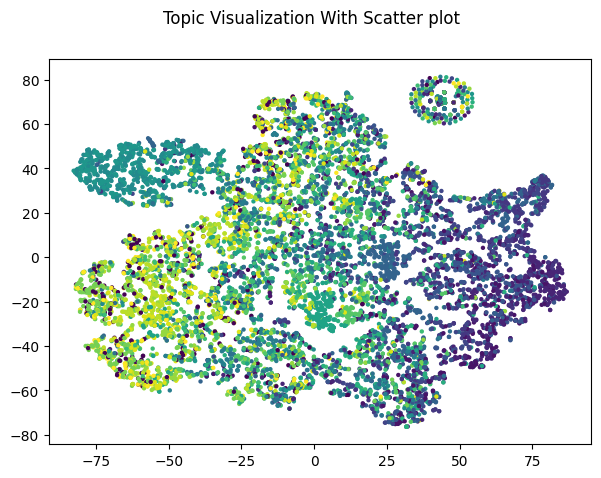

In [25]:
plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1],
c = dataset.target,
s = 10, # size
edgecolor='none'
)

plt.suptitle('Topic Visualization With Scatter plot')
plt.show()


# Optimizing the max_features

In [19]:
vectorizer = TfidfVectorizer(stop_words='english')
test = vectorizer.fit_transform(df_news['clean_doc'])

num_unique_terms = len(vectorizer.get_feature_names_out()) #melihat berapa banyak features(words) yang bisa kita tentukan untuk modelling menggunakan number unique
num_unique_terms

64748

In [20]:
# membandingkan beberapa nilai untuk max features dengan clustering kmeans serta silhouette score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Menetukan nilai-nilai max_features values yang akan dieksplor
max_features_values = [1000, 2000, 3000, 4000, 5000, 10000, 20000]

best_max_features = None
best_silhouette_score = -1  # memasang angka rendah untuk silhouette score

for max_features in max_features_values: #iterasi untuk membandingkan tiap nilai max features
    vectorizer = TfidfVectorizer(stop_words='english',
                                 max_features=max_features,
                                 max_df=0.5,
                                 smooth_idf=True)

    X = vectorizer.fit_transform(df_news['clean_doc'])

    # Membuat clustering
    kmeans = KMeans(n_clusters=5, random_state=42)
    cluster_labels = kmeans.fit_predict(X)

    # Menghitung nilai silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)

    if silhouette_avg > best_silhouette_score: # Menentukan best max features dengan melihat silhoutte score yang tertinggi
        best_silhouette_score = silhouette_avg
        best_max_features = max_features

print("Best max_features:", best_max_features)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Best max_features: 1000


Setelah dilakukan iterasi untuk beberapa nilai max_features, ditunjukkan bahwa nilai 100 merupakan nilai yang paling cocok. Maka dari itu, tidak diperlukan untuk menaikkan parameternya.